In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [2]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



100%|██████████| 170M/170M [00:08<00:00, 20.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


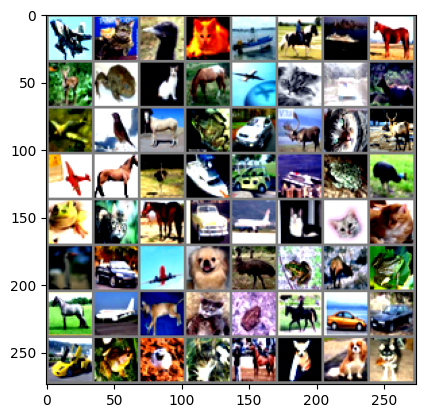

airplane cat bird cat ship horse ship horse deer frog cat horse airplane cat ship deer airplane bird horse frog automobile deer cat deer airplane horse bird ship automobile ship frog bird frog cat horse automobile airplane cat cat cat bird automobile airplane dog bird frog deer frog horse airplane dog cat frog horse automobile automobile automobile frog bird cat horse dog dog dog


In [3]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Linear projection of flattened patches
        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Projection layers for query, key, and value
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  # Batch, Sequence length, Embedding dimension

        # Project to query, key, value
        qkv = self.qkv_proj(x)  # (B, N, 3 * D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (B, num_heads, N, head_dim)

        # Scaled dot-product attention
        # (B, num_heads, N, head_dim) @ (B, num_heads, head_dim, N) -> (B, num_heads, N, N)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention weights to values
        # (B, num_heads, N, N) @ (B, num_heads, N, head_dim) -> (B, num_heads, N, head_dim)
        context = torch.matmul(attn_probs, v)
        
        # Reshape back to original dimensions
        # (B, num_heads, N, head_dim) -> (B, N, D)
        context = context.transpose(1, 2).reshape(B, N, D)
        
        # Final projection
        out = self.out_proj(context)
        return out


class ViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        # Layer Norm 1 (for attention)
        self.norm1 = nn.LayerNorm(input_dim)
        # Multi-head self-attention
        self.attn = MultiHeadSelfAttention(input_dim, num_heads, dropout)
        # Layer Norm 2 (for MLP)
        self.norm2 = nn.LayerNorm(input_dim)
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pre-LayerNorm architecture as in the original paper
        # First attention block with residual connection
        x = x + self.attn(self.norm1(x))
        # Then MLP block with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class ViTClassifier(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, dropout=0.0
    ):
        super().__init__()
        
        # Create config for patch embedding
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }
        
        # Patch embedding layer
        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        # Initialize with truncated normal distribution
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.transformer = nn.Sequential(
            *[ViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
        # Layer normalization for the final output
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Get batch size
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed  # (B, 1 + num_patches, embed_dim)
        x = self.dropout(x)
        
        # Apply transformer blocks
        x = self.transformer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0]  # (B, embed_dim)
        
        # Classification head
        x = self.head(x)  # (B, num_classes)
        
        return x

Using device: cuda

Training configuration 1/8: embed128_hidden512_heads4_layers4
Epoch [1/25], Step [200/782], Loss: 1.9508, Acc: 27.71%
Epoch [1/25], Step [400/782], Loss: 1.7626, Acc: 30.86%
Epoch [1/25], Step [600/782], Loss: 1.6911, Acc: 33.26%
Epoch [1/25] - Test Loss: 1.6001, Test Acc: 42.17%
Epoch [2/25], Step [200/782], Loss: 1.5423, Acc: 43.60%
Epoch [2/25], Step [400/782], Loss: 1.4811, Acc: 45.18%
Epoch [2/25], Step [600/782], Loss: 1.4381, Acc: 46.04%
Epoch [2/25] - Test Loss: 1.3697, Test Acc: 49.80%
Epoch [3/25], Step [200/782], Loss: 1.3627, Acc: 50.20%
Epoch [3/25], Step [400/782], Loss: 1.3239, Acc: 51.20%
Epoch [3/25], Step [600/782], Loss: 1.3078, Acc: 51.62%
Epoch [3/25] - Test Loss: 1.2545, Test Acc: 54.62%
Epoch [4/25], Step [200/782], Loss: 1.2523, Acc: 54.80%
Epoch [4/25], Step [400/782], Loss: 1.2263, Acc: 55.25%
Epoch [4/25], Step [600/782], Loss: 1.2089, Acc: 55.66%
Epoch [4/25] - Test Loss: 1.2000, Test Acc: 56.82%
Epoch [5/25], Step [200/782], Loss: 1.1656

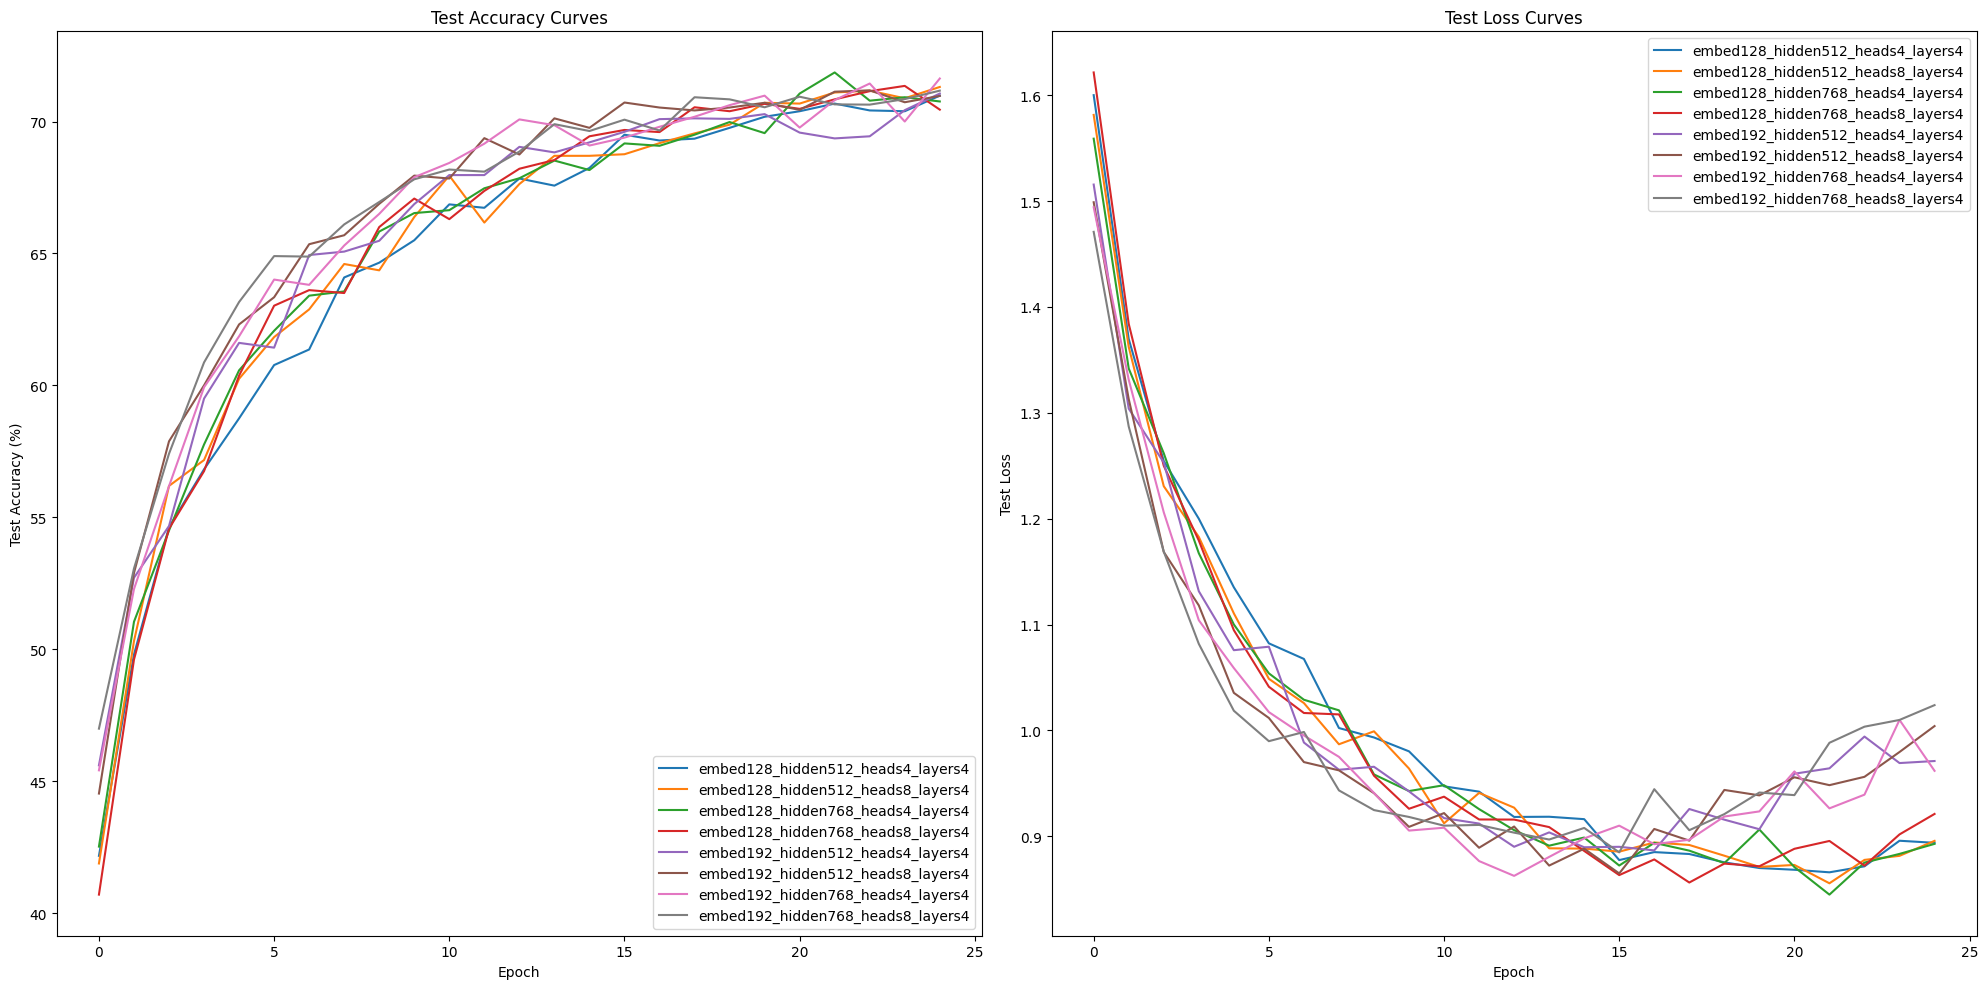

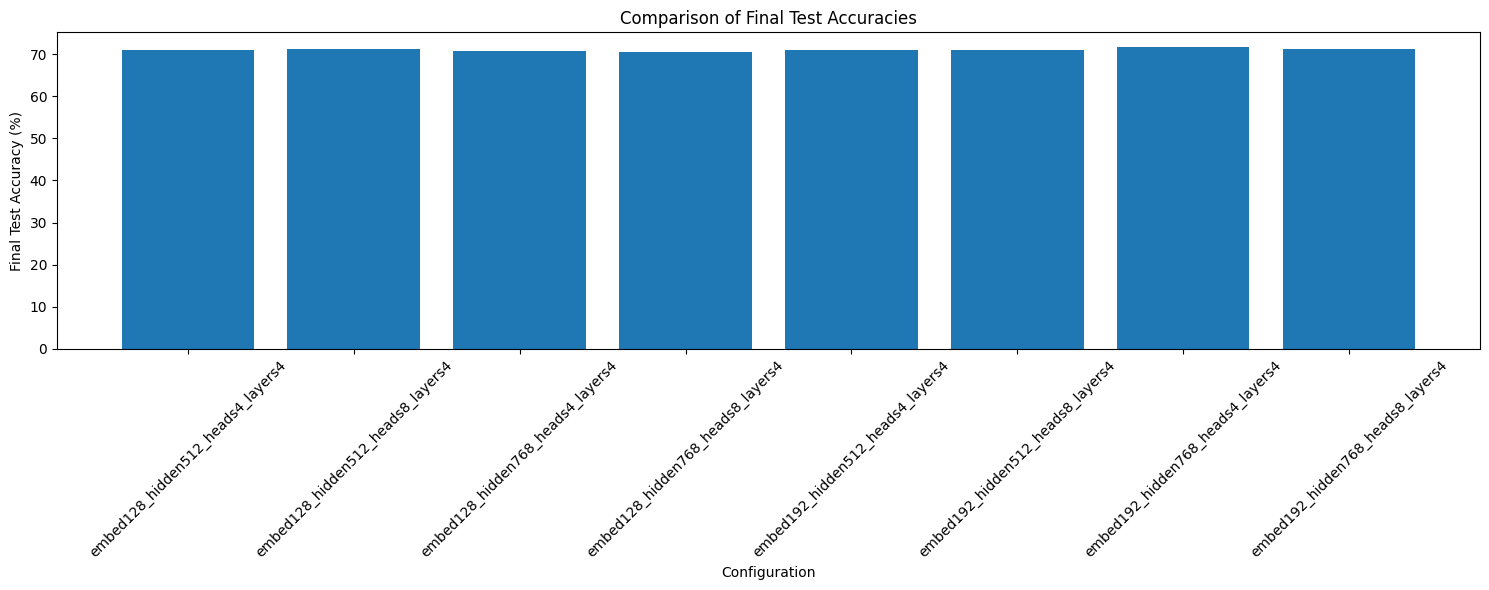


Results Summary:
----------------------------------------------------------------------------------------------------
Configuration                  | Embed Dim  | Hidden Dim | Heads    | Layers   | Test Acc   | Time (s)  
----------------------------------------------------------------------------------------------------
embed192_hidden768_heads4_layers4 | 192        | 768        | 4        | 4        | 71.63%    | 650.65
embed128_hidden512_heads8_layers4 | 128        | 512        | 8        | 4        | 71.31%    | 603.83
embed192_hidden768_heads8_layers4 | 192        | 768        | 8        | 4        | 71.17%    | 685.50
embed192_hidden512_heads4_layers4 | 192        | 512        | 4        | 4        | 71.06%    | 615.61
embed128_hidden512_heads4_layers4 | 128        | 512        | 4        | 4        | 70.98%    | 565.18
embed192_hidden512_heads8_layers4 | 192        | 512        | 8        | 4        | 70.97%    | 658.14
embed128_hidden768_heads4_layers4 | 128        | 768     

{'embed128_hidden512_heads4_layers4': {'embed_dim': 128,
  'hidden_dim': 512,
  'num_heads': 4,
  'num_layers': 4,
  'final_test_acc': 70.98,
  'final_test_loss': 0.8938538037287961,
  'test_accs': [42.17,
   49.8,
   54.62,
   56.82,
   58.75,
   60.77,
   61.36,
   64.09,
   64.65,
   65.5,
   66.86,
   66.73,
   67.84,
   67.57,
   68.24,
   69.5,
   69.28,
   69.35,
   69.76,
   70.18,
   70.39,
   70.68,
   70.42,
   70.39,
   70.98],
  'test_losses': [1.6001087138607244,
   1.3697498452131915,
   1.25447809772127,
   1.2000213421074448,
   1.1352255295036704,
   1.0822689369985252,
   1.0675487711930731,
   1.0022557233549227,
   0.993354489089577,
   0.9802471813122937,
   0.9472062215683567,
   0.9421831077071512,
   0.9182842305511426,
   0.9184703720603019,
   0.9161898550713897,
   0.8775302874054879,
   0.8850782479450201,
   0.8832716228096349,
   0.8753872473908079,
   0.8700210283136671,
   0.8683849890140971,
   0.8659737506869493,
   0.871637387829981,
   0.89579810629

In [6]:
import time
import itertools

def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Compute statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Print progress (less frequently)
            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/200:.4f}, Acc: {100.*correct/total:.2f}%')
                running_loss = 0.0
        
        # Calculate epoch training statistics
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_test_loss = test_loss / len(testloader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return train_accuracies, test_accuracies, test_losses

# Main hyperparameter tuning function
def hyperparameter_tuning(trainloader, testloader):
    # Fixed parameters
    image_size = 32
    patch_size = 4
    num_channels = 3
    num_classes = 10
    dropout = 0.1
    batch_size = 64
    learning_rate = 1e-4
    num_epochs = 25  # Reduced for faster hyperparameter search
    
    # Hyperparameters to tune (2 options for each)
    embed_dims = [128, 192]
    hidden_dims = [512, 768]
    num_heads_options = [4, 8]
    num_layers_options = [4]
    
    # Use CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load dataset
    trainloader, testloader = trainloader, testloader
    
    # Create all combinations of hyperparameters
    hyperparameter_combinations = list(itertools.product(embed_dims, hidden_dims, num_heads_options, num_layers_options))
    
    # Dictionary to store results
    results = {}
    
    for i, (embed_dim, hidden_dim, num_heads, num_layers) in enumerate(hyperparameter_combinations):
        config_name = f"embed{embed_dim}_hidden{hidden_dim}_heads{num_heads}_layers{num_layers}"
        print(f"\n{'='*50}")
        print(f"Training configuration {i+1}/{len(hyperparameter_combinations)}: {config_name}")
        print(f"{'='*50}")
        
        # Create and initialize model
        model = ViTClassifier(
            image_size=image_size,
            patch_size=patch_size,
            num_channels=num_channels,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout
        )
        model = model.to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=learning_rate)
        
        # Train and evaluate
        start_time = time.time()
        train_accs, test_accs, test_losses = train_and_evaluate(
            model, trainloader, testloader, criterion, optimizer, device, num_epochs)
        training_time = time.time() - start_time
        
        # Store results
        results[config_name] = {
            'embed_dim': embed_dim,
            'hidden_dim': hidden_dim,
            'num_heads': num_heads,
            'num_layers': num_layers,
            'final_test_acc': test_accs[-1],
            'final_test_loss': test_losses[-1],
            'test_accs': test_accs,
            'test_losses': test_losses,
            'training_time': training_time
        }
        
        print(f"Configuration {config_name} completed in {training_time:.2f} seconds.")
        print(f"Final test accuracy: {test_accs[-1]:.2f}%")
    
    # Find best configuration
    best_config = max(results.items(), key=lambda x: x[1]['final_test_acc'])
    best_config_name = best_config[0]
    best_accuracy = best_config[1]['final_test_acc']
    
    print("\n\n" + "="*50)
    print(f"Best configuration: {best_config_name}")
    print(f"Best test accuracy: {best_accuracy:.2f}%")
    print("="*50)
    
    # Plot results
    plt.figure(figsize=(20, 10))
    
    # Plot test accuracy over epochs for each configuration
    plt.subplot(1, 2, 1)
    for config_name, config_data in results.items():
        plt.plot(config_data['test_accs'], label=config_name)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Curves')
    plt.legend()
    
    # Plot test loss over epochs for each configuration
    plt.subplot(1, 2, 2)
    for config_name, config_data in results.items():
        plt.plot(config_data['test_losses'], label=config_name)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title('Test Loss Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('hyperparameter_tuning_results.png')
    plt.show()
    
    # Bar plot of final test accuracies
    plt.figure(figsize=(15, 6))
    configs = list(results.keys())
    accuracies = [results[config]['final_test_acc'] for config in configs]
    
    # Create bar plots
    plt.bar(configs, accuracies)
    plt.xlabel('Configuration')
    plt.ylabel('Final Test Accuracy (%)')
    plt.title('Comparison of Final Test Accuracies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('final_accuracies_comparison.png')
    plt.show()
    
    # Create a table of results
    print("\nResults Summary:")
    print("-" * 100)
    print(f"{'Configuration':<30} | {'Embed Dim':<10} | {'Hidden Dim':<10} | {'Heads':<8} | {'Layers':<8} | {'Test Acc':<10} | {'Time (s)':<10}")
    print("-" * 100)
    
    for config_name, config_data in sorted(results.items(), key=lambda x: x[1]['final_test_acc'], reverse=True):
        print(f"{config_name:<30} | {config_data['embed_dim']:<10} | {config_data['hidden_dim']:<10} | "
              f"{config_data['num_heads']:<8} | {config_data['num_layers']:<8} | "
              f"{config_data['final_test_acc']:.2f}%    | {config_data['training_time']:.2f}")
    
    return results

hyperparameter_tuning(trainloader, testloader)